## Summary

---

## Imports

In [1]:
import concurrent.futures
import contextlib
import itertools
import os
import tempfile
import urllib.request
from datetime import datetime
from pathlib import Path

import dotenv
import elaspic2 as el2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import synapseclient
import synapseutils
import torch
from elaspic2.plugins.rosetta_ddg import RosettaDDG
from kmbio import PDB
from kmtools import structure_tools
from tqdm.auto import tqdm

## Parameters

In [2]:
NOTEBOOK_DIR = Path("30_cagi6_mapk1").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/30_cagi6_mapk1')

In [3]:
UNIPROT_ID = "P28482"

UNIPROT_ID

'P28482'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [5]:
version = datetime.now().isoformat(timespec="hours")

version

'2021-09-13T18'

## Download data

In [6]:
def download(url, filename):
    urllib.request.urlretrieve(url, filename)

In [7]:
def load_sequence(sequence_file):
    with sequence_file.open("rt") as fin:
        data = fin.read()
    chunks = []
    for line in data.split("\n"):
        if line.startswith(">"):
            continue
        chunks.append(line.strip())
    return "".join(chunks)

In [8]:
if not NOTEBOOK_DIR.joinpath("validation.py").is_file():
    dotenv.load_dotenv("../.env")
    syn = synapseclient.Synapse()
    syn.login(os.environ["SYNAPSE_USERNAME"], os.environ["SYNAPSE_PASSWORD"])
    _ = synapseutils.syncFromSynapse(syn, "syn25955327", path=NOTEBOOK_DIR)

In [9]:
sequence_file = NOTEBOOK_DIR.joinpath(f"{UNIPROT_ID}.fasta")

if not sequence_file.is_file():
    download(f"https://www.uniprot.org/uniprot/{UNIPROT_ID}.fasta", sequence_file)

sequence = load_sequence(sequence_file)

In [10]:
structure_file = NOTEBOOK_DIR.joinpath(f"{UNIPROT_ID}.pdb")

if not structure_file.is_file():
    download(f"https://alphafold.ebi.ac.uk/files/AF-{UNIPROT_ID}-F1-model_v1.pdb", structure_file)

with structure_file.open("r") as fin:
    structure_blob = fin.read()

In [11]:
alignment_file = NOTEBOOK_DIR.joinpath(f"{UNIPROT_ID}.a3m.gz")


@contextlib.contextmanager
def api_gateway(*args, **kwargs):
    from requests_ip_rotator import ApiGateway

    gateway = ApiGateway(*args, **kwargs)
    try:
        gateway.start()
        yield gateway
    finally:
        gateway.shutdown()


def get_alignment(sequence, gateway):
    from elaspic2.plugins.alphafold2 import mmseqs2

    while True:
        try:
            alignment = mmseqs2.run_mmseqs2([sequence], gateway=gateway)[0]
            break
        except Exception as e:
            print(e)
            time.sleep(10)
            continue
    assert alignment[1] == f"{sequence}\n"
    return alignment


if not alignment_file.is_file():
    from elaspic2.plugins.alphafold2 import mmseqs2

    dotenv.load_dotenv("../.env")

    with api_gateway(mmseqs2.MMSEQS2_HOST_URL) as gateway:
        alignment = get_alignment(sequence, gateway)
        alignment_df = pd.DataFrame({"alignment": alignment})
        pq.write_table(pa.Table.from_pandas(alignment_df, preserve_index=False), alignment_file)

alignment = pq.read_table(alignment_file).to_pandas()["alignment"].values.tolist()

## Load data

In [12]:
def mutation_matches_sequence(mutation, sequence):
    wt, pos, mut = mutation[0], mutation[1:-1], mutation[-1]
    pos = int(pos)
    return sequence[pos - 1] == wt

In [13]:
def sequence_matches_structure(sequence, structure_blob):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(structure_blob)
        structure = PDB.load(tmp_file.name)

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    return sequence == chain_sequence

In [14]:
result_template_df = pd.read_csv(NOTEBOOK_DIR.joinpath("mapk1_predictions.tsv"), sep="\t")

result_template_df.head(2)

,MAPK1-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment
0,p.E33Q,*,*,*,*,*,*,*
1,p.E81K,*,*,*,*,*,*,*


In [15]:
result_df = result_template_df.copy()
result_df["mut"] = result_df["MAPK1-variant"].str[2:]

In [16]:
assert all([mutation_matches_sequence(mut, sequence) for mut in result_df["mut"]])

In [17]:
assert sequence_matches_structure(sequence, structure_blob)

In [18]:
assert alignment[1] == f"{sequence}\n"

## Run Rosetta

In [19]:
rosetta_ddg_data = RosettaDDG.build(
    structure_file,
    protocol="cartesian_ddg",
    energy_function="beta_nov16_cart",
    interface=0,
)

In [20]:
def rosetta_ddg_worker(mut, data):
    results = RosettaDDG.analyze_mutation(f"A_{mut}", data)
    results = {"mut": mut} | {f"rosetta_{key}": value for key, value in results.items()}
    return results

In [21]:
rosetta_results_file = NOTEBOOK_DIR.joinpath("rosetta-results.parquet")

if rosetta_results_file.is_file():
    rosetta_results_df = pq.read_table(rosetta_results_file).to_pandas()
else:
    with concurrent.futures.ThreadPoolExecutor(len(result_df)) as pool:
        rosetta_results = list(
            tqdm(
                pool.map(
                    rosetta_ddg_worker,
                    result_df["mut"].values.tolist(),
                    itertools.repeat(rosetta_ddg_data),
                ),
                total=len(result_df),
            )
        )
    rosetta_results_df = pd.DataFrame(rosetta_results)
    pq.write_table(pa.Table.from_pandas(rosetta_results_df, preserve_index=False), rosetta_results_file)

## Run `ELASPIC2`

### Initialize the `ELASPIC2` model



In [22]:
model = el2.ELASPIC2(device=device)

Some weights of the model checkpoint at /home/kimlab5/strokach/workspace/elaspic/elaspic2/src/elaspic2/plugins/protbert/data/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Make predictions

In [23]:
protein_features = model.build(
    structure_file=structure_file,
    protein_sequence=sequence,
    ligand_sequence=None,
    remove_hetatms=True,
)

protein_features

ELASPIC2Data(is_interface=False, protbert_data=ProtBertData(sequence='MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNVNKVRVAIKKISPFEHQTYCQRTLREIKILLRFRHENIIGINDIIRAPTIEQMKDVYIVQDLMETDLYKLLKTQHLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLLNTTCDLKICDFGLARVADPDHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINLKARNYLLSLPHKNKVPWNRLFPNADSKALDLLDKMLTFNPHKRIEVEQALAHPYLEQYYDPSDEPIAEAPFKFDMELDDLPKEKLKELIFEETARFQPGYRS'), proteinsolver_data=Data(edge_attr=[18572, 2], edge_index=[2, 18572], x=[360]))

In [24]:
mutation_features = list(
    tqdm(
        (model.analyze_mutation(mut, protein_features) for mut in result_df["mut"]),
        total=len(result_df),
    )
)

  0%|          | 0/11 [00:00<?, ?it/s]

In [25]:
# In all cases, higher scores means less stable (same as ΔΔG) 
result_df["protbert_score"] = [
    f["protbert_core_score_wt"] - f["protbert_core_score_mut"] for f in mutation_features
]
result_df["proteinsolver_score"] = [
    f["proteinsolver_core_score_wt"] - f["proteinsolver_core_score_mut"] for f in mutation_features
]
result_df["el2_score"] = model.predict_mutation_effect(mutation_features).tolist()

In [26]:
# In all cases, higher scores means less stable (same as ΔΔG)
result_df["protbert_ratio"] = [
    f["protbert_core_score_mut"] / f["protbert_core_score_wt"] for f in mutation_features
]
result_df["proteinsolver_ratio"] = [
    f["proteinsolver_core_score_mut"] / f["proteinsolver_core_score_wt"] for f in mutation_features
]
result_df["el2_ratio"] = (0.5 / model.predict_mutation_effect(mutation_features)).tolist()

### Add Rosetta score

In [27]:
rosetta_results_df["rosetta_dg_mut"] = (
    rosetta_results_df["rosetta_dg_change"] + rosetta_results_df["rosetta_dg_wt"]
)
assert np.allclose(
    rosetta_results_df["rosetta_dg_change"],
    rosetta_results_df["rosetta_dg_mut"] - rosetta_results_df["rosetta_dg_wt"],
)

rosetta_results_df["rosetta_dg_score"] = rosetta_results_df["rosetta_dg_change"]
rosetta_results_df["rosetta_dg_ratio"] = (
    rosetta_results_df["rosetta_dg_wt"] / rosetta_results_df["rosetta_dg_mut"]
)

In [28]:
try:
    del result_df["rosetta_dg_score"], result_df["rosetta_dg_ratio"]
except KeyError:
    pass

result_df = result_df.merge(
    rosetta_results_df[["mut", "rosetta_dg_score", "rosetta_dg_ratio"]], on="mut", how="left"
)

### Visualize output

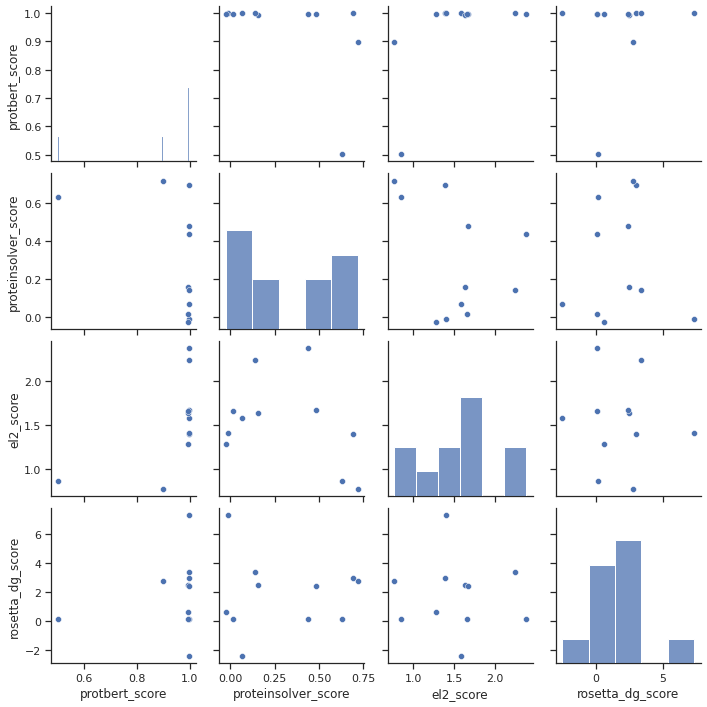

In [29]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    result_df[["protbert_score", "proteinsolver_score", "el2_score", "rosetta_dg_score"]]
)

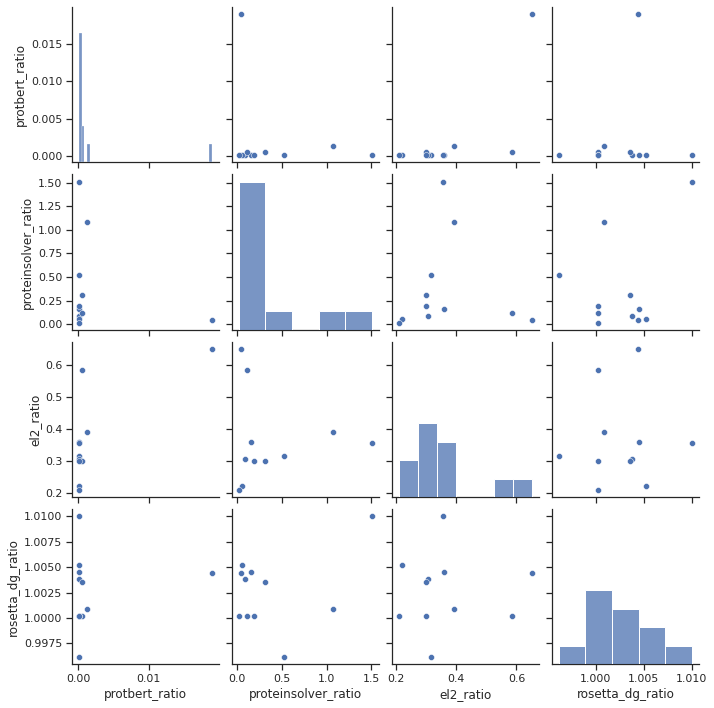

In [30]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    result_df[["protbert_ratio", "proteinsolver_ratio", "el2_ratio", "rosetta_dg_ratio"]]
)

## Write results

In [31]:
output_dir = NOTEBOOK_DIR.joinpath("results")
output_dir.mkdir(exist_ok=True)

output_dir

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/30_cagi6_mapk1/results')

In [32]:
%%file {output_dir}/strokach_desc.md
# Submission for CAGI6—MAPK1 challenge

## Overview

- `strokach_modelnumber_1.tsv` → Predictions made using ELASPIC2 [1].
- `strokach_modelnumber_2.tsv` → Predictions made using ProteinSolver [2].
- `strokach_modelnumber_3.tsv` → Predictions made using ProtBert [3].
- `strokach_modelnumber_4.tsv` → Predictions made using Rosetta's cartesian_ddg protocol.

## References

- [1] Strokach, A., Lu, T.Y., Kim, P.M., 2021. ELASPIC2 (EL2): Combining Contextualized Language Models and Graph Neural Networks to Predict Effects of Mutations. Journal of Molecular Biology, Computation Resources for Molecular Biology 433, 166810. https://doi.org/10.1016/j.jmb.2021.166810
- [2] Strokach, A., Becerra, D., Corbi-Verge, C., Perez-Riba, A., Kim, P.M., 2020. Fast and Flexible Protein Design Using Deep Graph Neural Networks. Cell Systems. https://doi.org/10.1016/j.cels.2020.08.016
- [3] Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., Gibbs, T., Feher, T., Angerer, C., Steinegger, M., Bhowmik, D., Rost, B., 2020. ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing. bioRxiv 2020.07.12.199554. https://doi.org/10.1101/2020.07.12.199554


Overwriting /home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/30_cagi6_mapk1/results/strokach_desc.md


In [33]:
result_dfs = {}
for i, metric in enumerate(["el2", "proteinsolver", "protbert", "rosetta_dg"]):
    result_dfs[metric] = result_df.copy()
    result_dfs[metric]["DDG-NotPO4"] = -result_dfs[metric][f"{metric}_score"].values
    result_dfs[metric]["Standard-Deviation-DDG-NotPO4"] = 1.0
    result_dfs[metric]["DDG-PO4"] = -result_dfs[metric][f"{metric}_score"].values
    result_dfs[metric][" Standard-Deviation-DDG-PO4"] = 1.0
    result_dfs[metric]["Ratio-kcat/Km"] = result_dfs[metric][f"{metric}_ratio"].values
    result_dfs[metric]["Standard-Deviation-Ratio-kcat/Km"] = 1.0
    result_dfs[metric]["Comment"] = "*"

    print(metric)
    display(result_dfs[metric].head())

    output_file = output_dir.joinpath(f"strokach_modelnumber_{i + 1}.tsv")
    result_dfs[metric][result_template_df.columns].to_csv(output_file, sep="\t", index=False)
    !python {NOTEBOOK_DIR}/validation.py {output_file}

el2


,MAPK1-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,proteinsolver_score,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio
0,p.E33Q,-1.582201,1.0,-1.582201,1.0,0.316016,1.0,*,E33Q,0.998343,0.066731,1.582201,0.000155,0.519324,0.316016,-2.457000,0.996143
1,p.E81K,-1.630727,1.0,-1.630727,1.0,0.306612,1.0,*,E81K,0.994183,0.159303,1.630727,0.000131,0.090255,0.306612,2.456000,1.003807
2,p.L121I,-1.390088,1.0,-1.390088,1.0,0.359689,1.0,*,L121I,0.999190,0.692270,1.390088,0.000108,0.157240,0.359689,2.965667,1.004512
3,p.R135K,-1.664755,1.0,-1.664755,1.0,0.300345,1.0,*,R135K,0.997200,0.481067,1.664755,0.000537,0.310411,0.300345,2.395333,1.003528
4,p.D162G,-2.243989,1.0,-2.243989,1.0,0.222818,1.0,*,D162G,0.998402,0.140639,2.243989,0.000142,0.053119,0.222818,3.375667,1.005196


The file's format is valid! You are good to submit now!
proteinsolver


,MAPK1-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,proteinsolver_score,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio
0,p.E33Q,-0.066731,1.0,-0.066731,1.0,0.519324,1.0,*,E33Q,0.998343,0.066731,1.582201,0.000155,0.519324,0.316016,-2.457000,0.996143
1,p.E81K,-0.159303,1.0,-0.159303,1.0,0.090255,1.0,*,E81K,0.994183,0.159303,1.630727,0.000131,0.090255,0.306612,2.456000,1.003807
2,p.L121I,-0.692270,1.0,-0.692270,1.0,0.157240,1.0,*,L121I,0.999190,0.692270,1.390088,0.000108,0.157240,0.359689,2.965667,1.004512
3,p.R135K,-0.481067,1.0,-0.481067,1.0,0.310411,1.0,*,R135K,0.997200,0.481067,1.664755,0.000537,0.310411,0.300345,2.395333,1.003528
4,p.D162G,-0.140639,1.0,-0.140639,1.0,0.053119,1.0,*,D162G,0.998402,0.140639,2.243989,0.000142,0.053119,0.222818,3.375667,1.005196


The file's format is valid! You are good to submit now!
protbert


,MAPK1-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,proteinsolver_score,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio
0,p.E33Q,-0.998343,1.0,-0.998343,1.0,0.000155,1.0,*,E33Q,0.998343,0.066731,1.582201,0.000155,0.519324,0.316016,-2.457000,0.996143
1,p.E81K,-0.994183,1.0,-0.994183,1.0,0.000131,1.0,*,E81K,0.994183,0.159303,1.630727,0.000131,0.090255,0.306612,2.456000,1.003807
2,p.L121I,-0.999190,1.0,-0.999190,1.0,0.000108,1.0,*,L121I,0.999190,0.692270,1.390088,0.000108,0.157240,0.359689,2.965667,1.004512
3,p.R135K,-0.997200,1.0,-0.997200,1.0,0.000537,1.0,*,R135K,0.997200,0.481067,1.664755,0.000537,0.310411,0.300345,2.395333,1.003528
4,p.D162G,-0.998402,1.0,-0.998402,1.0,0.000142,1.0,*,D162G,0.998402,0.140639,2.243989,0.000142,0.053119,0.222818,3.375667,1.005196


The file's format is valid! You are good to submit now!
rosetta_dg


,MAPK1-variant,DDG-NotPO4,Standard-Deviation-DDG-NotPO4,DDG-PO4,Standard-Deviation-DDG-PO4,Ratio-kcat/Km,Standard-Deviation-Ratio-kcat/Km,Comment,mut,protbert_score,proteinsolver_score,el2_score,protbert_ratio,proteinsolver_ratio,el2_ratio,rosetta_dg_score,rosetta_dg_ratio
0,p.E33Q,2.457000,1.0,2.457000,1.0,0.996143,1.0,*,E33Q,0.998343,0.066731,1.582201,0.000155,0.519324,0.316016,-2.457000,0.996143
1,p.E81K,-2.456000,1.0,-2.456000,1.0,1.003807,1.0,*,E81K,0.994183,0.159303,1.630727,0.000131,0.090255,0.306612,2.456000,1.003807
2,p.L121I,-2.965667,1.0,-2.965667,1.0,1.004512,1.0,*,L121I,0.999190,0.692270,1.390088,0.000108,0.157240,0.359689,2.965667,1.004512
3,p.R135K,-2.395333,1.0,-2.395333,1.0,1.003528,1.0,*,R135K,0.997200,0.481067,1.664755,0.000537,0.310411,0.300345,2.395333,1.003528
4,p.D162G,-3.375667,1.0,-3.375667,1.0,1.005196,1.0,*,D162G,0.998402,0.140639,2.243989,0.000142,0.053119,0.222818,3.375667,1.005196


The file's format is valid! You are good to submit now!
